# TODO

* poprawna implementacja ConVar
* różne inpaintery:
    * nasz
    * shallow MFA
    * **randomowy**
* w przypadku naszego inpaintera
    * pretrenowany, zamrożony
    * dotrenowywanie
        * loss z samej klasyfikacji
        * NLL + klasyfikacja
        * pretrenowany inpainter
        * zamrożony inpainter
    * jakie wizualizacje wyjść?


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [4]:
from inpainting.datasets.mask_coding import UNKNOWN_LOSS, UNKNOWN_NO_LOSS, KNOWN
from inpainting.datasets.utils import RandomRectangleMaskConfig, random_mask_fn
from inpainting.datasets.mnist import train_val_datasets as mnist_tv_datasets
from inpainting.visualizations.digits import img_with_mask
from inpainting.inpainters.linear_heads import LinearHeadsInpainter
from inpainting.visualizations import visualizations_utils as vis_utils
from inpainting.custom_layers import ConVar
from time import time

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [6]:
ds_train, ds_val = mnist_tv_datasets(
    save_path=Path("/home/mprzewiezlikowski/uj/.data/"),
    mask_configs=(
        RandomRectangleMaskConfig(UNKNOWN_LOSS, 14, 14, 0,0),
    )
)


In [7]:
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=64, shuffle=False)


In [8]:
def eval_classifier(
    inp_clas,
    epoch: int,
    data_loaders: dict,
    device: torch.device,
    metric_fns: dict,
) -> dict:
    classifier.eval()
    fold_metrics = dict()
    
    for fold, dl in data_loaders.items():
        metrics = []
        
        for (X, J), Y in dl:
            X, J, Y = [t.to(device) for t in [X, J, Y]]
            Y_pred, PMAD_pred = inp_clas(X,J)
            metrics.append({
                m_name: metric_fn(X, J, Y, Y_pred).item()
                for m_name, metric_fn in metric_fns.items()
            })
    
        fold_metrics[fold] = metrics
    
    return dict(
        epoch=epoch,
        metrics={
            m_name: {
                fold: np.mean([m[m_name] for m in f_metrics])
                for fold, f_metrics in fold_metrics.items()
            }
            for m_name in metric_fns.keys()
        }
    )

In [9]:
crossentropy_metric = lambda X, J, Y, Y_pred: nn.functional.cross_entropy(Y_pred, Y)
accuracy_metric = lambda X, J, Y, Y_pred: (Y_pred.argmax(dim=1) == Y).float().mean()

In [10]:
class InpaintingClassifier(nn.Module):
    def __init__(self, inpainter, convar_layer, classifier, keep_inpainting_gradient_in_classification: bool = False):
        super().__init__()
        self.inpainter = inpainter
        self.convar = convar_layer
        self.classifier = classifier
        self.keep_inpainting_gradient_in_classification = keep_inpainting_gradient_in_classification
        
        
    def forward(self, X, J):
        t0 = time()
        X_masked = X * (J==KNOWN)
        X_J = torch.cat([X_masked, J], dim=1)
        t1 = time()
        P, M, A, D = self.inpainter(X, J)
        t2 = time()

        b, c, h, w = X.shape
        b, n, chw = M.shape
        b, n, l, chw = A.shape
        
        P_r = P
        M_r = M.reshape(b, n, c, h, w)
        A_r = A.reshape(b, n, l, c, h, w)
        D_r = D.reshape(b, n, c, h, w)
        
        if not self.keep_inpainting_gradient_in_classification:
            P_r, M_r, A_r, D_r = [t.detach() for t in [P_r, M_r, A_r, D_r]]
        
        t3 = time()
        
        convar_out = self.convar(X, J, P_r, M_r, A_r, D_r)
        t4 = time()
        classification_result = self.classifier(convar_out)
        inpainting_result = (P, M, A, D)
        t5 = time()
        
        den = t5 - t0
        prep = t1 - t0
        inp = t2 - t1
        resh = t3 - t2
        convar = t4 - t3
        clas = t5 - t4
        times = [prep, inp, resh, convar, clas]

        
        return classification_result, inpainting_result
        
    

In [11]:
inpainter = LinearHeadsInpainter(
    n_mixes=1,
    c_h_w=(1,28,28),
    last_channels=32,
    a_width=4
)

checkpoint = torch.load("../results/inpainting/mnist/mgr_sanity_check_v0/training.state", map_location="cpu")
inpainter.load_state_dict(checkpoint["inpainter"])

<All keys matched successfully>

In [12]:
classifier = nn.Sequential(
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(7*7*64, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [13]:
convar = ConVar(nn.Conv2d(1, 32, kernel_size=3, padding=1))

In [18]:
inp_clas = InpaintingClassifier(inpainter, convar, classifier, keep_inpainting_gradient_in_classification=True)
inp_clas =  inp_clas.to(device)

# for p in inp_clas.inpainter.parameters():
#     p.requires_grad = False

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[ 0.01320833  0.00062023 -0.0223706   0.01044747 -0.03524776  0.01457138
 -0.01973327 -0.00924754 -0.00150076  0.00688211]


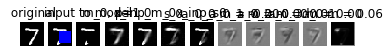

In [19]:
for (X,J), Y in dl_val:
    
    P, M, A, D = inpainter(X.to(device), J.to(device))

    x, j, p, m, a, d, y = [t.detach().cpu().numpy()[0] for t in [X, J, P, M, A, D, Y]]
    vis_utils.visualize_sample(x, j, p, m, a, d, y,)
    print(m[0, :10])

    plt.show()
    break


In [20]:
opt = torch.optim.Adam(inp_clas.parameters())


loss_fn = nn.CrossEntropyLoss()#.to(device)

history = []


for e in range(1):
    
    print(f"Epoch {e}")

    inp_clas.train()

    for (X, J), Y in dl_val:
        X, J, Y = [t.to(device) for t in [X, J, Y]]
        Y_pred, PMAD_pred = inp_clas(X, J)
        loss = loss_fn(Y_pred, Y)
        loss.backward()
        opt.step()
        opt.zero_grad()

    eval_results = eval_classifier(
        inp_clas,
        epoch=e,
        data_loaders={
            "train": dl_train,
            "val": dl_val
        },
        device=device,
        metric_fns=dict(
            cross_entropy=crossentropy_metric,
            accuracy=accuracy_metric
        )
    )
    history.append(eval_results)
    print(eval_results)

        

Epoch 0
{'epoch': 0, 'metrics': {'cross_entropy': {'train': 0.5368554631212373, 'val': 0.4651864295362667}, 'accuracy': {'train': 0.8150153251599147, 'val': 0.8326035031847133}}}


[ 0.16044188  0.49423796  0.50147074  0.40218326 -0.04351589 -0.1029804
 -0.05938498 -0.1096974  -0.08327479 -0.11825115]


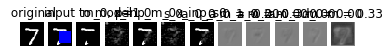

In [21]:
for (X,J), Y in dl_val:
    
    P, M, A, D = inpainter(X.to(device), J.to(device))

    x, j, p, m, a, d, y = [t.detach().cpu().numpy()[0] for t in [X, J, P, M, A, D, Y]]
    
    print(m[0, :10])
    vis_utils.visualize_sample(x, j, p, m, a, d, y,)
    
    plt.show()
    break


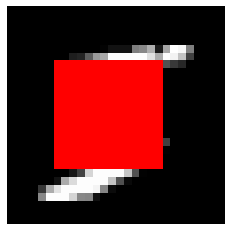

In [21]:
for (x,j), y in ds_train:
    
    break

img_with_mask(x, j)

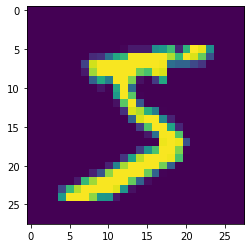